In [1]:
empty, eos, maxlend, maxlenh, maxlen, seed = 0,1, 25, 10, 35, 42

activation_rnn_size = 40 if maxlend else 0
nb_unknown_words = 10

# function names
FN0 = 'vocabulary-embedding'  # filename of vocab embeddings
FN1 = 'train'  # filename of model weights

# training variables
seed = 42
optimizer = 'adam'
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
regularizer = None

In [2]:
from os import path
import _pickle as pickle
from collections import Counter
import numpy as np
import os
from sklearn.model_selection import train_test_split
import _pickle as pickle
from os import path
import random
import json
import pickle
import h5py
import numpy as np
import keras.backend as K
import argparse
import os
import time
import random
import argparse
import json

import numpy as np
from keras.callbacks import TensorBoard
import random

import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.core import Lambda
import keras.backend as K
import numpy as np
from keras.models import load_model

import Levenshtein
import numpy as np
import random
from keras.preprocessing import sequence

desc_data_loc = "train.article.txt"
head_data_loc = "train.title.txt"


with open(desc_data_loc, 'r', encoding='utf-8') as f:
    desc_lines = f.read().split('\n')
with open(head_data_loc, 'r', encoding='utf-8') as f:
    head_lines = f.read().split('\n')
    
X_data, Y_data = [],[]
for i in range(len(desc_lines)):
    if( len(desc_lines[i].split()) <= maxlend and len(head_lines[i].split()) <= maxlenh-1 ):
        X_data.append(desc_lines[i].lower())
        Y_data.append(head_lines[i].lower())
print(len(X_data))


with open('tokens.pkl', 'wb') as fp:
            pickle.dump((Y_data[:500000],X_data[:500000]), fp, 2)

c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


FileNotFoundError: [Errno 2] No such file or directory: 'train.article.txt'

In [3]:
"""Generate intial word embedding for headlines and description.

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.
"""
import io

# static vars
FN = 'vocabulary-embedding'
seed = 42
vocab_size = 40000
embedding_dim = 100
lower = False

# index words
empty = 0  # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos + 1  # first real word

# set random seed
np.random.seed(seed)


def build_vocab(lst):
    """Return vocabulary for iterable `lst`."""
    vocab_count = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocab_count.items(), key=lambda x: -x[1])))
    return vocab, vocab_count


def load_text():
    """Return vocabulary for pickled headlines and descriptions."""
    # read tokenized headlines and descriptions
    with open('tokens.pkl', 'rb') as fp:
        headlines, desc = pickle.load(fp)

    # map headlines and descriptions to lower case
    if lower:
        headlines = [h.lower() for h in headlines]
        desc = [h.lower() for h in desc]

    return headlines, desc


def print_most_popular_tokens(vocab):
    """Print th most popular tokens in vocabulary dictionary `vocab`."""
    print('Most popular tokens:')
    print(vocab[:50])
    print('Total vocab size: {:,}'.format(len(vocab)))

'''
def plot_word_distributions(vocab, vocab_count):
    """Plot word distribution in headlines and discription."""
    plt.plot([vocab_count[w] for w in vocab])
    plt.gca().set_xscale("log", nonposx='clip')
    plt.gca().set_yscale("log", nonposy='clip')
    title = 'word distribution in headlines and discription'
    plt.title(title)
    plt.xlabel('rank')
    plt.ylabel('total appearances')
    plt.savefig(path.join(config.path_outputs, '{}.png'.format(title)))
'''


def get_idx(vocab):
    """Add empty and end-of-sentence tokens to vocabulary and return tuple (vocabulary, reverse-vocabulary)."""
    word2idx = dict((word, idx + start_idx) for idx, word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    idx2word = dict((idx, word) for word, idx in word2idx.items())
    return word2idx, idx2word


def get_glove():
    """Load GloVe embedding weights and indices."""
    glove_name = 'glove.6B.{}d.txt'.format(embedding_dim)
    glove_n_symbols = 0
    with io.open(glove_name, encoding="utf-8") as glovedata :
        for line in glovedata:
            glove_n_symbols+=1
    #glove_n_symbols = sum(1 for line in open(glove_name))
    print('{:,} GloVe symbols'.format(glove_n_symbols))

    # load embedding weights and index dictionary
    glove_index_dict = {}
    glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
    globale_scale = .1
    with io.open(glove_name, encoding="utf-8") as fp:
        i = 0
        for l in fp:
            l = l.strip().split()
            w = l[0]
            glove_index_dict[w] = i
            glove_embedding_weights[i, :] = list(map(float, l[1:]))
            i += 1
    glove_embedding_weights *= globale_scale
    print('GloVe std dev: {:.4f}'.format(glove_embedding_weights.std()))

    # add lower case version of the keys to the dict
    for w, i in glove_index_dict.items():
        w = w.lower()
        if w not in glove_index_dict:
            glove_index_dict[w] = i

    return glove_embedding_weights, glove_index_dict


def initialize_embedding(vocab_size, embedding_dim, glove_embedding_weights):
    """Use GloVe to initialize random embedding matrix with same scale as glove."""
    shape = (vocab_size, embedding_dim)
    scale = glove_embedding_weights.std() * np.sqrt(12) / 2  # uniform and not normal
    embedding = np.random.uniform(low=-scale, high=scale, size=shape)
    print('random-embedding/glove scale: {:.4f} std: {:.4f}'.format(scale, embedding.std()))
    return embedding


def copy_glove_weights(embedding, idx2word, glove_embedding_weights, glove_index_dict):
    """Copy from glove weights of words that appear in our short vocabulary (idx2word)."""
    c = 0
    for i in range(vocab_size):
        w = idx2word[i]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
        if g is None and w.startswith('#'):  # glove has no hastags (I think...)
            w = w[1:]
            g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
        if g is not None:
            embedding[i, :] = glove_embedding_weights[g, :]
            c += 1
    print('number of tokens, in small vocab: {:,} found in glove and copied to embedding: {:.4f}'.format(c, c / float(vocab_size)))
    return embedding


def build_word_to_glove(embedding, word2idx, idx2word, glove_index_dict, glove_embedding_weights):
    """Map full vocabulary to glove based on cosine distance."""
    glove_thr = 0.5
    word2glove = {}
    for w in word2idx:
        if w in glove_index_dict:
            g = w
        elif w.lower() in glove_index_dict:
            g = w.lower()
        elif w.startswith('#') and w[1:] in glove_index_dict:
            g = w[1:]
        elif w.startswith('#') and w[1:].lower() in glove_index_dict:
            g = w[1:].lower()
        else:
            continue
        word2glove[w] = g

    # for every word outside the embedding matrix find the closest word inside the mebedding matrix.
    # Use cos distance of GloVe vectors.
    # Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
    # Dont accept distances below `glove_thr`
    normed_embedding = embedding / np.array(
        [np.sqrt(np.dot(gweight, gweight)) for gweight in embedding])[:, None]

    nb_unknown_words = 100

    glove_match = []
    for w, idx in word2idx.items():
        if idx >= vocab_size - nb_unknown_words and w.isalpha() and w in word2glove:
            gidx = glove_index_dict[word2glove[w]]
            gweight = glove_embedding_weights[gidx, :].copy()

            # find row in embedding that has the highest cos score with gweight
            gweight /= np.sqrt(np.dot(gweight, gweight))
            score = np.dot(normed_embedding[:vocab_size - nb_unknown_words], gweight)
            while True:
                embedding_idx = score.argmax()
                s = score[embedding_idx]
                if s < glove_thr:
                    break
                if idx2word[embedding_idx] in word2glove:
                    glove_match.append((w, embedding_idx, s))
                    break
                score[embedding_idx] = -1

    glove_match.sort(key=lambda x: -x[2])
    print()
    print('# of GloVe substitutes found: {:,}'.format(len(glove_match)))

    # manually check that the worst substitutions we are going to do are good enough
    for orig, sub, score in glove_match[-10:]:
        print('{:.4f}'.format(score), orig, '=>', idx2word[sub])

    # return a lookup table of index of outside words to index of inside words
    return dict((word2idx[w], embedding_idx) for w, embedding_idx, _ in glove_match)


def to_dense_vector(word2idx, corpus, description, bins=50):
    """Create a dense vector representation of headlines."""
    data = [[word2idx[token] for token in txt.split()] for txt in corpus]
    #plt.hist(list(map(len, data)), bins=bins)
    #plt.savefig(path.join(config.path_outputs, '{}_distribution.png'.format(description)))
    return data


def summarize_vocab(vocab, vocab_count):
    """Print the most popular tokens and plot token distributions."""
    print_most_popular_tokens(vocab)
    #plot_word_distributions(vocab, vocab_count)


def main():
    """Generate intial word embedding for headlines and description."""
    headlines, desc = load_text()  # load headlines and descriptions
    vocab, vocab_count = build_vocab(headlines + desc)  # build vocabulary
    summarize_vocab(vocab, vocab_count)  # summarize vocabulary
    word2idx, idx2word = get_idx(vocab)  # add special tokens and get reverse vocab lookup
    glove_embedding_weights, glove_index_dict = get_glove()  # load GloVe data

    # initialize embedding
    embedding = initialize_embedding(vocab_size, embedding_dim, glove_embedding_weights)
    embedding = copy_glove_weights(embedding, idx2word, glove_embedding_weights, glove_index_dict)

    # map vocab to GloVe using cosine similarity
    glove_idx2idx = build_word_to_glove(embedding, word2idx, idx2word, glove_index_dict, glove_embedding_weights)

    # create a dense vector representation of headlines and descriptions
    description_vector = to_dense_vector(word2idx, desc, 'description')
    headline_vector = to_dense_vector(word2idx, headlines, 'headline')

    # write vocabulary to disk
    with open('{}.pkl'.format(FN), 'wb') as fp:
        pickle.dump((embedding, idx2word, word2idx, glove_idx2idx), fp, 2)

    # write data to disk
    with open('{}.data.pkl'.format(FN), 'wb') as fp:
        pickle.dump((description_vector, headline_vector), fp, 2)

if __name__ == '__main__':
    main()

Most popular tokens:
['.', 'the', 'in', 'a', 'to', ',', 'of', 'on', "'s", 'for', 'and', 'said', 'at', '<unk>', 'with', '##', 'has', 'is', 'as', 'from', 'new', 'an', 'wednesday', 'tuesday', 'thursday', 'after', 'his', 'was', 'friday', 'that', 'monday', 'by', 'percent', 'it', 'its', 'will', 'president', 'against', 'world', 'have', 'two', 'u.s.', 'prices', 'police', 'are', 'saturday', 'over', 'us', 'up', 'sunday']
Total vocab size: 90,816
400,000 GloVe symbols
GloVe std dev: 0.0408
random-embedding/glove scale: 0.0707 std: 0.0408
number of tokens, in small vocab: 38,633 found in glove and copied to embedding: 0.9658

# of GloVe substitutes found: 32,532
0.5001 hayne => charvis
0.5000 taranath => cagni
0.5000 croll => mccrary
0.5000 tartus => zaporizhia
0.5000 crouse => suggs
0.5000 hallett => woolsey
0.5000 felcor => accor
0.5000 kunin => teter
0.5000 osmar => legler
0.5000 domenic => dalibor


In [4]:
"""Utility methods."""

def join_ingredients(ingredients_listlist):
    """Join multiple lists of ingredients with ' , '."""
    return [' , '.join(i) for i in ingredients_listlist]


def get_flat_ingredients_list(ingredients_joined_train):
    """Flatten lists of ingredients encoded as a string into a single list."""
    return ' , '.join(ingredients_joined_train).split(' , ')


def section_print():
    """Memorized function keeping track of section number."""
    section_number = 0

    def inner(message):
        """Print section number."""
        global section_number
        section_number += 1
        print('Section {}: {}'.format(section_number, message))
    print('Section {}: initializing section function'.format(section_number))
    return inner


def is_filename_char(x):
    """Return True if x is an acceptable filename character."""
    if x.isalnum():
        return True
    if x in ['-', '_']:
        return True
    return False


def url_to_filename(filename):
    """Map a URL string to filename by removing unacceptable characters."""
    return "".join(x for x in filename if is_filename_char(x))


def prt(label, word_idx, idx2word):
    """Map `word_idx` list to words and print it with its associated `label`."""
    words = [idx2word[word] for word in word_idx]
    print('{}: {}\n'.format(label, ' '.join(words)))


def str_shape(x):
    """Format the dimension of numpy array `x` as a string."""
    return 'x'.join([str(element) for element in x.shape])


def load_embedding(nb_unknown_words):
    """Read word embeddings and vocabulary from disk."""
    with open('{}.pkl'.format(FN0), 'rb') as fp:
        embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
    vocab_size, embedding_size = embedding.shape
    print('dimension of embedding space for words: {:,}'.format(embedding_size))
    print('vocabulary size: {:,} the last {:,} words can be used as place holders for unknown/oov words'.
          format(vocab_size, nb_unknown_words))
    print('total number of different words: {:,}'.format(len(idx2word)))
    print('number of words outside vocabulary which we can substitue using glove similarity: {:,}'.
          format(len(glove_idx2idx)))
    print('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov): {:,}'.
          format(len(idx2word) - vocab_size - len(glove_idx2idx)))
    return embedding, idx2word, word2idx, glove_idx2idx


def load_data():
    """Read recipe data from disk."""
    with open('{}.data.pkl'.format(FN0), 'rb') as fp:
        X, Y = pickle.load(fp)
    print('number of examples', len(X), len(Y))
    return X, Y


def process_vocab(idx2word, vocab_size, oov0, nb_unknown_words):
    """Update vocabulary to account for unknown words."""
    # reserve vocabulary space for unkown words
    for i in range(nb_unknown_words):
        idx2word[vocab_size - 1 - i] = '<{}>'.format(i)

    # mark words outside vocabulary with ^ at their end
    for i in range(oov0, len(idx2word)):
        idx2word[i] = idx2word[i] + '^'

    # add empty word and end-of-sentence to vocab
    idx2word[empty] = '_'
    idx2word[eos] = '~'

    return idx2word


def load_split_data(nb_val_samples, seed):
    """Create train-test split."""
    # load data and create train test split
    X, Y = load_data()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=nb_val_samples, random_state=seed)
    del X, Y  # free up memory by removing X and Y
    return X_train, X_test, Y_train, Y_test


if __name__ == '__main__':
    print(url_to_filename('http://stackoverflow.com/questions/295135/turn-a-string-into-a-valid-filename'))

httpstackoverflowcomquestions295135turn-a-string-into-a-valid-filename


In [5]:
"""Create an LSTM model for recipe summarization."""

def inspect_model(model):
    """Print the structure of Keras `model`."""
    for i, l in enumerate(model.layers):
        print(i, 'cls={} name={}'.format(type(l).__name__, l.name))
        weights = l.get_weights()
        print_str = ''
        for weight in weights:
            print_str += str_shape(weight) + ' '
        print(print_str)
        print()


class SimpleContext(Lambda):
    """Class to implement `simple_context` method as a Keras layer."""

    def __init__(self, fn, rnn_size, **kwargs):
        """Initialize SimpleContext."""
        self.rnn_size = rnn_size
        super(SimpleContext, self).__init__(fn, **kwargs)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        """Compute mask of maxlend."""
        return input_mask[:, maxlend:]

    def get_output_shape_for(self, input_shape):
        """Get output shape for a given `input_shape`."""
        nb_samples = input_shape[0]
        n = 2 * (self.rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)


def create_model(vocab_size, embedding_size, LR, rnn_layers, rnn_size, embedding=None):
    """Construct and compile LSTM model."""
    # create a standard stacked LSTM
    if embedding is not None:
        embedding = [embedding]
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size,
                        input_length=maxlen,
                        W_regularizer=regularizer, dropout=p_emb, weights=embedding, mask_zero=True,
                        name='embedding_1'))
    for i in range(rnn_layers):
        lstm = LSTM(rnn_size, return_sequences=True,
                    W_regularizer=regularizer, U_regularizer=regularizer,
                    b_regularizer=regularizer, dropout_W=p_W, dropout_U=p_U,
                    name='lstm_{}'.format(i + 1))
        model.add(lstm)
        model.add(Dropout(p_dense, name='dropout_{}'.format(i + 1)))

    def simple_context(X, mask, n=activation_rnn_size):
        """Reduce the input just to its headline part (second half).

        For each word in this part it concatenate the output of the previous layer (RNN)
        with a weighted average of the outputs of the description part.
        In this only the last `rnn_size - activation_rnn_size` are used from each output.
        The first `activation_rnn_size` output is used to computer the weights for the averaging.
        """
        desc, head = X[:, :maxlend, :], X[:, maxlend:, :]
        head_activations, head_words = head[:, :, :n], head[:, :, n:]
        desc_activations, desc_words = desc[:, :, :n], desc[:, :, n:]

        # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
        # activation for every head word and every desc word
        activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2, 2))
        # make sure we dont use description words that are masked out
        if mask is not None:
            param = 1. - K.cast(mask[:, :maxlend], 'float32')
            activation_energies = activation_energies + -1e20 * K.expand_dims(param, 1)

        # for every head word compute weights for every desc word
        activation_energies = K.reshape(activation_energies, (-1, maxlend))
        activation_weights = K.softmax(activation_energies)
        activation_weights = K.reshape(activation_weights, (-1, maxlenh, maxlend))

        # for every head word compute weighted average of desc words
        desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2, 1))
        return K.concatenate((desc_avg_word, head_words))

    if activation_rnn_size:
        model.add(SimpleContext(simple_context, rnn_size, name='simplecontext_1'))

    model.add(TimeDistributed(Dense(
        vocab_size,
        W_regularizer=regularizer,
        b_regularizer=regularizer,
        name='time_distributed_2')))
    model.add(Activation('softmax', name='activation_1'))

    # opt = Adam(lr=LR)  # keep calm and reduce learning rate
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    K.set_value(model.optimizer.lr, np.float32(LR))
    return model

In [6]:
"""Generate samples.

Variation on https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
"""

def lpadd(x):
    """Left (pre) pad a description to maxlend and then add eos.

    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty] * (maxlend - n) + x + [eos]


def beamsearch(
        predict, start, k, maxsample, use_unk, empty, temperature, nb_unknown_words,
        vocab_size, model, batch_size, avoid=None, avoid_score=1):
    """Return k samples (beams) and their NLL scores, each sample is a sequence of labels.

    All samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples.
    """
    def sample(energy, n, temperature=temperature):
        """Sample at most n elements according to their energy."""
        n = min(n, len(energy))
        prb = np.exp(-np.array(energy) / temperature)
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb / z, 1))
            res.append(r)
            prb[r] = 0.  # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_k = 1  # samples that did not yet reached eos
    live_samples = [list(start)]
    live_scores = [0]

    while live_k:
        # for every possible live sample calc prob for every possible label
        probs = predict(live_samples, empty=empty, model=model, batch_size=batch_size)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:, None] - np.log(probs)
        cand_scores[:, empty] = 1e20
        if not use_unk:
            for i in range(nb_unknown_words):
                cand_scores[:, vocab_size - 1 - i] = 1e20

        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i, a[n]] += avoid_score

        live_scores = list(cand_scores.flatten())

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        ranks_dead = [r for r in ranks if r < n]
        ranks_live = [r - n for r in ranks if r >= n]

        dead_scores = [dead_scores[r] for r in ranks_dead]
        dead_samples = [dead_samples[r] for r in ranks_dead]

        live_scores = [live_scores[r] for r in ranks_live]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[1]
        live_samples = [live_samples[r // voc_size] + [r % voc_size] for r in ranks_live]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        zombie = [s[-1] == eos or len(s) > maxsample for s in live_samples]

        # add zombies to the dead
        dead_samples += [s for s, z in zip(live_samples, zombie) if z]
        dead_scores += [s for s, z in zip(live_scores, zombie) if z]
        # remove zombies from the living
        live_samples = [s for s, z in zip(live_samples, zombie) if not z]
        live_scores = [s for s, z in zip(live_scores, zombie) if not z]
        live_k = len(live_samples)

    return dead_samples + live_samples, dead_scores + live_scores


def keras_rnn_predict(samples, empty, model, batch_size):
    """For every sample, calculate probability for every possible label.

    You need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = list(map(len, samples))
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([prob[sample_length - maxlend - 1]
                     for prob, sample_length in zip(probs, sample_lengths)])


def vocab_fold(xs, oov0, glove_idx2idx, vocab_size, nb_unknown_words):
    """Convert list of word indices that may contain words outside vocab_size to words inside.

    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < oov0 else glove_idx2idx.get(x, x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= oov0])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x, vocab_size - 1 - min(i, nb_unknown_words - 1)) for i, x in enumerate(outside))
    xs = [outside.get(x, x) for x in xs]
    return xs


def vocab_unfold(desc, xs, oov0):
    """Covert a description to a list of word indices."""
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= oov0:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x, x) for x in xs]


def gensamples(
        skips, short, data, idx2word, oov0, glove_idx2idx, vocab_size,
        nb_unknown_words, avoid=None, avoid_score=1, **kwargs):
    """Generate text samples."""
    # unpack data
    X, Y = data

    # if data is full dataset pick a random header and description
    if not isinstance(X[0], int):
        i = random.randint(0, len(X) - 1)
        x = X[i]
        y = Y[i]
    else:
        x = X
        y = Y

    # print header and description
    print('HEAD:', ' '.join(idx2word[w] for w in y[:maxlenh]))
    print('DESC:', ' '.join(idx2word[w] for w in x[:maxlend]))

    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indeicies
        if isinstance(avoid, str) or isinstance(avoid[0], int):
            avoid[avoid]
        avoid = [a.split() if isinstance(a, str) else a for a in avoid]
        avoid = [[a] for a in avoid]

    print('HEADS:')
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend, len(x)), max(maxlend, len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start, oov0, glove_idx2idx, vocab_size, nb_unknown_words)
        sample, score = beamsearch(
            predict=keras_rnn_predict,
            start=fold_start,
            maxsample=maxlen,
            empty=empty,
            nb_unknown_words=nb_unknown_words,
            vocab_size=vocab_size,
            avoid=avoid,
            **kwargs
        )
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s, start, scr) for s, scr in zip(sample, score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample, oov0)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w // (256 * 256)) + chr((w // 256) % 256) + chr(w % 256)

        if short:
            distance = min([100] + [-Levenshtein.jaro(code, c) for c in codes])
            if distance > -0.6:
                print(score, ' '.join(words))
        else:
                print(score, ' '.join(words))
        codes.append(code)
    return samples


In [7]:
"""Data generator generates batches of inputs and outputs/labels for training.

The inputs are each made from two parts. The first maxlend words are the original description, followed by `eos` followed by the headline which we want to predict, except for the last word in the headline which is always `eos` and then `empty` padding until `maxlen` words.

For each, input, the output is the headline words (without the start `eos` but with the ending `eos`) padded with `empty` words up to `maxlenh` words. The output is also expanded to be y-hot encoding of each word.

To be more realistic, the second part of the input should be the result of generation and not the original headline.
Instead we will flip just `nflips` words to be from the generator, but even this is too hard and instead
implement flipping in a naive way (which consumes less time.) Using the full input (description + eos + headline) generate predictions for outputs. Faor nflips random words from the output, replace the original word with the word with highest probability from the prediction.
"""

def flip_headline(x, nflips, model, debug, oov0, idx2word):
    """Flip some of the words in the second half (headline) with words predicted by the model."""
    if nflips is None or model is None or nflips <= 0:
        return x

    batch_size = len(x)
    assert np.all(x[:, maxlend] == eos)
    probs = model.predict(x, verbose=0, batch_size=batch_size)
    x_out = x.copy()
    for b in range(batch_size):
        # pick locations we want to flip
        # 0...maxlend-1 are descriptions and should be fixed
        # maxlend is eos and should be fixed
        flips = sorted(random.sample(range(maxlend + 1, maxlen), nflips))
        if debug and b < debug:
            print(b)
        for input_idx in flips:
            if x[b, input_idx] == empty or x[b, input_idx] == eos:
                continue
            # convert from input location to label location
            # the output at maxlend (when input is eos) is feed as input at maxlend+1
            label_idx = input_idx - (maxlend + 1)
            prob = probs[b, label_idx]
            w = prob.argmax()
            if w == empty:  # replace accidental empty with oov
                w = oov0
            if debug and b < debug:
                print('{} => {}'.format(idx2word[x_out[b, input_idx]], idx2word[w]),)
            x_out[b, input_idx] = w
        if debug and b < debug:
            print()
    return x_out


def conv_seq_labels(xds, xhs, nflips, model, debug, oov0, glove_idx2idx, vocab_size, nb_unknown_words, idx2word):
    """Convert description and hedlines to padded input vectors; headlines are one-hot to label."""
    batch_size = len(xhs)
    assert len(xds) == batch_size
    x = [
        vocab_fold(lpadd(xd) + xh, oov0, glove_idx2idx, vocab_size, nb_unknown_words)
        for xd, xh in zip(xds, xhs)]  # the input does not have 2nd eos
    x = sequence.pad_sequences(x, maxlen=maxlen, value=empty, padding='post', truncating='post')
    x = flip_headline(x, nflips=nflips, model=model, debug=debug, oov0=oov0, idx2word=idx2word)

    y = np.zeros((batch_size, maxlenh, vocab_size))
    for i, xh in enumerate(xhs):
        xh = vocab_fold(xh, oov0, glove_idx2idx, vocab_size, nb_unknown_words) + [eos] + [empty] * maxlenh  # output does have a eos at end
        xh = xh[:maxlenh]
        y[i, :, :] = np_utils.to_categorical(xh, vocab_size)

    return x, y


def gen(Xd, Xh, batch_size, nb_batches, nflips, model, debug, oov0, glove_idx2idx, vocab_size, nb_unknown_words, idx2word):
    """Yield batches.

    for training use nb_batches=None
    for validation generate deterministic results repeating every nb_batches
    """
    # while training it is good idea to flip once in a while the values of the headlines from the
    # value taken from Xh to value generated by the model.
    c = nb_batches if nb_batches else 0
    while True:
        xds = []
        xhs = []
        if nb_batches and c >= nb_batches:
            c = 0
        new_seed = random.randint(0, 2e10)
        random.seed(c + 123456789 + seed)
        for b in range(batch_size):
            t = random.randint(0, len(Xd) - 1)

            xd = Xd[t]
            s = random.randint(min(maxlend, len(xd)), max(maxlend, len(xd)))
            xds.append(xd[:s])

            xh = Xh[t]
            s = random.randint(min(maxlenh, len(xh)), max(maxlenh, len(xh)))
            xhs.append(xh[:s])

        # undo the seeding before we yield inorder not to affect the caller
        c += 1
        random.seed(new_seed)

        yield conv_seq_labels(
            xds,
            xhs,
            nflips=nflips,
            model=model,
            debug=debug,
            oov0=oov0,
            glove_idx2idx=glove_idx2idx,
            vocab_size=vocab_size,
            nb_unknown_words=nb_unknown_words,
            idx2word=idx2word,
        )


In [10]:
"""Train a sequence to sequence model.

This script is sourced from Siraj Rival
https://github.com/llSourcell/How_to_make_a_text_summarizer/blob/master/train.ipynb
"""

epochs=10
rnn_size=512
rnn_layers=3
nsamples=640
nflips=0
temperature=.8
lr=0.0001
warm_start='store_true'
batch_size=32

# set sample sizes
nb_train_samples = np.int(np.floor(nsamples / batch_size)) * batch_size  # num training samples
nb_val_samples = nb_train_samples  # num validation samples

# seed weight initialization
random.seed(seed)
np.random.seed(seed)

embedding, idx2word, word2idx, glove_idx2idx = load_embedding(nb_unknown_words)
vocab_size, embedding_size = embedding.shape
oov0 = vocab_size - nb_unknown_words
idx2word = process_vocab(idx2word, vocab_size, oov0, nb_unknown_words)
X_train, X_test, Y_train, Y_test = load_split_data(nb_val_samples, seed)

# print a sample recipe to make sure everything looks right
print('Random head, description:')
i = 811
prt('H', Y_train[i], idx2word)
prt('D', X_train[i], idx2word)

# save model initialization parameters
model_params = (dict(
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    LR=lr,
    rnn_layers=rnn_layers,
    rnn_size=rnn_size,
))
with open('model_params.json', 'w') as f:
    json.dump(model_params, f)


model = create_model(
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    LR=lr,
    embedding=embedding,
    rnn_layers=rnn_layers,
    rnn_size=rnn_size,
)
inspect_model(model)

# load pre-trained model weights
FN1_filename = '{}.hdf5'.format(FN1)
if warm_start and FN1 and os.path.exists(FN1_filename):
    model.load_weights(FN1_filename)
    print('Model weights loaded from {}'.format(FN1_filename))

# print samples before training
gensamples(
    skips=2,
    k=10,
    batch_size=batch_size,
    short=False,
    temperature=temperature,
    use_unk=True,
    model=model,
    data=(X_test, Y_test),
    idx2word=idx2word,
    oov0=oov0,
    glove_idx2idx=glove_idx2idx,
    vocab_size=vocab_size,
    nb_unknown_words=nb_unknown_words,
)

# get train and validation generators
r = next(gen(X_train, Y_train, batch_size=batch_size, nb_batches=None, nflips=None, model=None, debug=False, oov0=oov0, glove_idx2idx=glove_idx2idx, vocab_size=vocab_size, nb_unknown_words=nb_unknown_words, idx2word=idx2word))
traingen = gen(X_train, Y_train, batch_size=batch_size, nb_batches=None, nflips=nflips, model=model, debug=False, oov0=oov0, glove_idx2idx=glove_idx2idx, vocab_size=vocab_size, nb_unknown_words=nb_unknown_words, idx2word=idx2word)
valgen = gen(X_test, Y_test, batch_size=batch_size, nb_batches=nb_val_samples // batch_size, nflips=None, model=None, debug=False, oov0=oov0, glove_idx2idx=glove_idx2idx, vocab_size=vocab_size, nb_unknown_words=nb_unknown_words, idx2word=idx2word)

# define callbacks for training
callbacks = [TensorBoard(
    log_dir=str(time.time()),
    histogram_freq=0, write_graph=False, write_images=False)]

# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights(FN1_filename, overwrite=True)

# print samples after training
samples = gensamples(
    skips=2,
    k=10,
    batch_size=batch_size,
    short=False,
    temperature=temperature,
    use_unk=True,
    model=model,
    data=(X_test, Y_test),
    idx2word=idx2word,
    oov0=oov0,
    glove_idx2idx=glove_idx2idx,
    vocab_size=vocab_size,
    nb_unknown_words=nb_unknown_words,
)


dimension of embedding space for words: 100
vocabulary size: 40,000 the last 10 words can be used as place holders for unknown/oov words
total number of different words: 90,818
number of words outside vocabulary which we can substitue using glove similarity: 32,532
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov): 18,286
number of examples 500000 500000
Random head, description:
H: un chief condemns somalia suicide blast

D: un chief ban ki-moon thursday denounced a suicide attack on a somali graduation ceremony which left ## people dead including three government ministers .



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(40000, 100, input_length=35, weights=[array([[-..., mask_zero=True, name="embedding_1", embeddings_regularizer=None)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_1", kernel_regularizer=None, bias_regularizer=None, recurrent_regularizer=None, dropout=0, recurrent_dropout=0)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_2", kernel_regularizer=None, bias_regularizer

0 cls=Embedding name=embedding_1
40000x100 

1 cls=LSTM name=lstm_1
100x2048 512x2048 2048 

2 cls=Dropout name=dropout_1


3 cls=LSTM name=lstm_2
512x2048 512x2048 2048 

4 cls=Dropout name=dropout_2


5 cls=LSTM name=lstm_3
512x2048 512x2048 2048 

6 cls=Dropout name=dropout_3


7 cls=SimpleContext name=simplecontext_1


8 cls=TimeDistributed name=time_distributed_2
944x40000 40000 

9 cls=Activation name=activation_1


HEAD: obama clinton pledge us support for aids fight
DESC: president barack obama and secretary of state hillary rodham clinton have pledged the support of the united states in the global fight against aids .
HEADS:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`


Epoch 1/10
640/640 [==============================] - 1029s 2s/step - loss: 7.7715 - val_loss: 7.5011
Epoch 2/10
640/640 [==============================] - 1026s 2s/step - loss: 7.3500 - val_loss: 7.1762
Epoch 3/10
640/640 [==============================] - 1025s 2s/step - loss: 7.0481 - val_loss: 6.9895
Epoch 4/10
640/640 [==============================] - 1028s 2s/step - loss: 6.8892 - val_loss: 6.8327
Epoch 5/10
640/640 [==============================] - 1028s 2s/step - loss: 6.7359 - val_loss: 6.6672
Epoch 6/10
640/640 [==============================] - 1030s 2s/step - loss: 6.5877 - val_loss: 6.5413
Epoch 7/10
640/640 [==============================] - 1031s 2s/step - loss: 6.4747 - val_loss: 6.4282
Epoch 8/10
640/640 [==============================] - 1032s 2s/step - loss: 6.3919 - val_loss: 6.3386
Epoch 9/10
640/640 [==============================] - 1033s 2s/step - loss: 6.3057 - val_loss: 6.2819
Epoch 10/10
640/640 [==============================] - 1036s 2s/step - loss: 6.232

In [11]:
"""Predict a title for a recipe."""

# set seeds in random libraries
seed = 42
random.seed(seed)
np.random.seed(seed)


def load_weights(model, filepath):
    """Load all weights possible into model from filepath.

    This is a modified version of keras load_weights that loads as much as it can
    if there is a mismatch between file and model. It returns the weights
    of the first layer in which the mismatch has happened
    """
    print('Loading', filepath, 'to', model.name)
    with h5py.File(filepath, mode='r') as f:
        # new file format
        layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]

        # we batch weight value assignments in a single backend call
        # which provides a speedup in TensorFlow.
        weight_value_tuples = []
        for name in layer_names:
            print(name)
            g = f[name]
            weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
            if len(weight_names):
                weight_values = [g[weight_name] for weight_name in weight_names]
                try:
                    layer = model.get_layer(name=name)
                except:
                    layer = None
                if not layer:
                    print('failed to find layer', name, 'in model')
                    print('weights', ' '.join(str_shape(w) for w in weight_values))
                    print('stopping to load all other layers')
                    weight_values = [np.array(w) for w in weight_values]
                    break
                symbolic_weights = layer.trainable_weights + layer.non_trainable_weights
                weight_value_tuples += zip(symbolic_weights, weight_values)
                weight_values = None
        K.batch_set_value(weight_value_tuples)
    return weight_values


def main(sample_str=None):
    '''
    """Predict a title for a recipe."""
    # load model parameters used for training
    with open('model_params.json', 'r') as f:
        model_params = json.load(f)

    # create placeholder model
    model = create_model(**model_params)

    # load weights from training run
    load_weights(model, '{}.hdf5'.format(FN1))
    '''
    # load recipe titles and descriptions
    with open('vocabulary-embedding.data.pkl', 'rb') as fp:
        X_data, Y_data = pickle.load(fp)

    # load vocabulary
    with open('{}.pkl'.format(FN0), 'rb') as fp:
        embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
    vocab_size, embedding_size = embedding.shape
    oov0 = vocab_size - nb_unknown_words

    if sample_str is None:
        # load random recipe description if none provided
        i = np.random.randint(len(X_data))
        sample_str = ''
        sample_title = ''
        for w in X_data[i]:
            sample_str += idx2word[w] + ' '
        for w in Y_data[i]:
            sample_title += idx2word[w] + ' '
        y = Y_data[i]
        print('Randomly sampled recipe:')
        print(sample_title)
        print(sample_str)
    else:
        sample_title = ''
        y = [eos]

    x = [word2idx[w.rstrip('^')] for w in sample_str.split()]

    samples = gensamples(
        skips=2,
        k=1,
        batch_size=2,
        short=False,
        temperature=1.,
        use_unk=True,
        model=model,
        data=(x, y),
        idx2word=idx2word,
        oov0=oov0,
        glove_idx2idx=glove_idx2idx,
        vocab_size=vocab_size,
        nb_unknown_words=nb_unknown_words,
    )

    headline = samples[0][0][len(samples[0][1]):]
    ' '.join(idx2word[w] for w in headline)

if __name__ == '__main__':
    main(sample_str=X_data[5002])

HEAD: <eos>
DESC: an indonesian court on thursday found a man guilty of complicity in a dormitory explosion here last year which killed three acehnese students .
HEADS:
49.32130187749863 prosecutor police ecuadorean attacks australians man death in


In [9]:
X_data[5001]

'some ### demonstrators rallied in central prague on thursday and burned an israeli flag to protest against the military offensive in the palestinian territories .'

In [15]:
main(X_data[1])

HEAD: <eos>
DESC: australian shares closed down #.# percent monday following a weak lead from the united states and lower commodity prices , dealers said .
HEADS:
17.893243551254272 european prices close #.# percent down


In [18]:
main(None)

Randomly sampled recipe:
coyotes select top-rated goalie 
the loudest applause during saturday 's entire nhl entry draft came when the coyotes , of all teams , made their first-round selection . 
HEAD: coyotes select top-rated goalie
DESC: the loudest applause during saturday 's entire nhl entry draft came when the coyotes , of all teams , made their first-round selection .
HEADS:
69.51377285271883 travis control with plans third deal away has tie


In [19]:
main(None)

Randomly sampled recipe:
cartoons give social satire and multiculturalism a whirl 
television 's world of animation is tumbling out far beyond the confines of saturday-morning cartoons for selling toys . 
HEAD: cartoons give social satire and multiculturalism a whirl
DESC: television 's world of animation is tumbling out far beyond the confines of saturday-morning cartoons for selling toys .
HEADS:
48.186828911304474 nissan with chicken for as concerned in
62.302042067050934 <unk> marines baxter pay festivals drought use


In [20]:
main(None)

Randomly sampled recipe:
venezuela issues bonds for us$ # billion 
venezuela will issue bonds for us$ # billion -lrb- euro### million -rrb- on the local market , a government official said monday . 
HEAD: venezuela issues bonds for us$ # billion
DESC: venezuela will issue bonds for us$ # billion -lrb- euro### million -rrb- on the local market , a government official said monday .
HEADS:
58.19530925154686 restrictions french surge broadcasting to in #.# outsider


In [21]:
main(None)

Randomly sampled recipe:
aussies keep firm grip on ashes 
world champions australia retained the ashes here on sunday with a ##-# victory over great britain in the third and final test . 
HEAD: aussies keep firm grip on ashes
DESC: world champions australia retained the ashes here on sunday with a ##-# victory over great britain in the third and final test .
HEADS:
40.859228014945984 u.s. with haiti team for 's


In [22]:
main(None)

Randomly sampled recipe:
arsenal manager accuses critics of racist thinking 
arsenal manager arsene wenger on friday defended the lack of english players on his gunners squad and accused his critics of racist thinking . 
HEAD: arsenal manager accuses critics of racist thinking
DESC: arsenal manager arsene wenger on friday defended the lack of english players on his gunners squad and accused his critics of racist thinking .
HEADS:
37.46626925468445 schalk says their at to out


In [23]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights(FN1_filename, overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1037s 2s/step - loss: 6.1753 - val_loss: 6.1589
Epoch 2/10
640/640 [==============================] - 1037s 2s/step - loss: 6.1332 - val_loss: 6.1029
Epoch 3/10
640/640 [==============================] - 1043s 2s/step - loss: 6.0746 - val_loss: 6.0598
Epoch 4/10
640/640 [==============================] - 1041s 2s/step - loss: 6.0262 - val_loss: 6.0143
Epoch 5/10
640/640 [==============================] - 1049s 2s/step - loss: 5.9716 - val_loss: 5.9640
Epoch 6/10
640/640 [==============================] - 1045s 2s/step - loss: 5.9246 - val_loss: 5.9356
Epoch 7/10
640/640 [==============================] - 1042s 2s/step - loss: 5.8926 - val_loss: 5.9018
Epoch 8/10
640/640 [==============================] - 1043s 2s/step - loss: 5.8604 - val_loss: 5.8788
Epoch 9/10
640/640 [==============================] - 1041s 2s/step - loss: 5.8247 - val_loss: 5.8510
Epoch 10/10
640/640 [==============================] - 1041s 2s/step - loss: 5.785

In [24]:
main(X_data[5002])

HEAD: <eos>
DESC: an indonesian court on thursday found a man guilty of complicity in a dormitory explosion here last year which killed three acehnese students .
HEADS:
50.53463840484619 mourning sentences killed ## out accident skull


In [26]:
main(None)

Randomly sampled recipe:
cities sticking visitors with sports stadium costs 
one way to save money when you travel is to avoid any city with a serious professional sports franchise . 
HEAD: cities sticking visitors with sports stadium costs
DESC: one way to save money when you travel is to avoid any city with a serious professional sports franchise .
HEADS:
35.682562828063965 more frigid prices rivalry
76.46098418399924 trail nurses but huge a homeland trump of film


In [27]:
traingen = gen(X_train, Y_train, batch_size=batch_size, nb_batches=None, nflips=5, model=model, debug=False, oov0=oov0, glove_idx2idx=glove_idx2idx, vocab_size=vocab_size, nb_unknown_words=nb_unknown_words, idx2word=idx2word)
valgen = gen(X_test, Y_test, batch_size=batch_size, nb_batches=nb_val_samples // batch_size, nflips=None, model=None, debug=False, oov0=oov0, glove_idx2idx=glove_idx2idx, vocab_size=vocab_size, nb_unknown_words=nb_unknown_words, idx2word=idx2word)

# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights(FN1_filename, overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
640/640 [==============================] - 1140s 2s/step - loss: 5.6642 - val_loss: 5.8062
Epoch 2/10
640/640 [==============================] - 1140s 2s/step - loss: 5.6829 - val_loss: 5.7766
Epoch 3/10
640/640 [==============================] - 1131s 2s/step - loss: 5.6340 - val_loss: 5.7428
Epoch 4/10
640/640 [==============================] - 1119s 2s/step - loss: 5.6087 - val_loss: 5.7224
Epoch 5/10
640/640 [==============================] - 1122s 2s/step - loss: 5.5869 - val_loss: 5.6892
Epoch 6/10
640/640 [==============================] - 1128s 2s/step - loss: 5.5568 - val_loss: 5.6771
Epoch 7/10
640/640 [==============================] - 1121s 2s/step - loss: 5.5303 - val_loss: 5.6525
Epoch 8/10
640/640 [==============================] - 1121s 2s/step - loss: 5.5137 - val_loss: 5.6334
Epoch 9/10
640/640 [==============================] - 1126s 2s/step - loss: 5.4644 - val_loss: 5.6266
Epoch 10/10
640/640 [==============================] - 1128s 2s/step - loss: 5.442

In [28]:
main(X_data[5002])

HEAD: <eos>
DESC: an indonesian court on thursday found a man guilty of complicity in a dormitory explosion here last year which killed three acehnese students .
HEADS:
34.98368340730667 woman convicted returns in claims child in


In [51]:
Y_data[1]

'australian stocks close down #.# percent'

In [29]:
main(sample_str=X_data[1])

HEAD: <eos>
DESC: australian shares closed down #.# percent monday following a weak lead from the united states and lower commodity prices , dealers said .
HEADS:
17.665944039821625 australian shares up up #.# of in


In [30]:
main(None)

Randomly sampled recipe:
katrina changes future for entire family 
last week , jamie and kenny <unk> gathered their four children around the kitchen table to discuss their future . 
HEAD: katrina changes future for entire family
DESC: last week , jamie and kenny <unk> gathered their four children around the kitchen table to discuss their future .
HEADS:
51.71024560928345 sweet draw back gelatin help and at
75.09842837551696 band flag die were cases defaced city the disease


In [31]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights(FN1_filename, overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1124s 2s/step - loss: 5.4146 - val_loss: 5.5801
Epoch 2/10
640/640 [==============================] - 1120s 2s/step - loss: 5.4007 - val_loss: 5.5484
Epoch 3/10
640/640 [==============================] - 1112s 2s/step - loss: 5.3649 - val_loss: 5.5254
Epoch 4/10
640/640 [==============================] - 1111s 2s/step - loss: 5.3384 - val_loss: 5.5066
Epoch 5/10
640/640 [==============================] - 1119s 2s/step - loss: 5.2994 - val_loss: 5.4803
Epoch 6/10
640/640 [==============================] - 1117s 2s/step - loss: 5.2729 - val_loss: 5.4642
Epoch 7/10
640/640 [==============================] - 1117s 2s/step - loss: 5.2575 - val_loss: 5.4531
Epoch 8/10
640/640 [==============================] - 1116s 2s/step - loss: 5.2429 - val_loss: 5.4500
Epoch 9/10
640/640 [==============================] - 1112s 2s/step - loss: 5.2223 - val_loss: 5.4322
Epoch 10/10
640/640 [==============================] - 1109s 2s/step - loss: 5.190

In [32]:
main(X_data[5002])

HEAD: <eos>
DESC: an indonesian court on thursday found a man guilty of complicity in a dormitory explosion here last year which killed three acehnese students .
HEADS:
46.94695073366165 indonesian produces life death in boston shot kill


In [33]:
main(sample_str=X_data[1])

HEAD: <eos>
DESC: australian shares closed down #.# percent monday following a weak lead from the united states and lower commodity prices , dealers said .
HEADS:
7.943446628749371 australian shares close #.# #.# percent percent


In [34]:
main(None)

Randomly sampled recipe:
quake survivors bury their dead ramos tours devastated island 
president fidel ramos toured quake stricken mindoro rescue thursday as the death toll climbed to ## and mass burials began . 
HEAD: quake survivors bury their dead ramos tours devastated island
DESC: president fidel ramos toured quake stricken mindoro rescue thursday as the death toll climbed to ## and mass burials began .
HEADS:
51.887038588523865 ahmadinejad confidence makes population positive deaths victims in
72.65343773114728 haiti jack emergency blames arrived eruption closes road space


In [ ]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights(FN1_filename, overwrite=True)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


640/640 [==============================] - 1117s 2s/step - loss: 5.2685 - val_loss: 5.3897
Epoch 2/10
640/640 [==============================] - 1114s 2s/step - loss: 5.2456 - val_loss: 5.3753
Epoch 3/10
640/640 [==============================] - 1115s 2s/step - loss: 5.2135 - val_loss: 5.3626
Epoch 4/10
640/640 [==============================] - 1117s 2s/step - loss: 5.2129 - val_loss: 5.3505
Epoch 5/10
640/640 [==============================] - 1124s 2s/step - loss: 5.1890 - val_loss: 5.3369
Epoch 6/10
640/640 [==============================] - 1119s 2s/step - loss: 5.1612 - val_loss: 5.3083
Epoch 7/10
478/640 [=====================>........] - ETA: 3:49 - loss: 5.1777

In [21]:
"""Predict a title for a recipe."""

# set seeds in random libraries
seed = 42
random.seed(seed)
np.random.seed(seed)


def load_weights(model, filepath):
    """Load all weights possible into model from filepath.

    This is a modified version of keras load_weights that loads as much as it can
    if there is a mismatch between file and model. It returns the weights
    of the first layer in which the mismatch has happened
    """
    print('Loading', filepath, 'to', model.name)
    with h5py.File(filepath, mode='r') as f:
        # new file format
        layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]
        print(layer_names)
    
        # we batch weight value assignments in a single backend call
        # which provides a speedup in TensorFlow.
        weight_value_tuples = []
        for name in layer_names:
            print(name)
            g = f[name]
            weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
            if len(weight_names):
                weight_values = [g[weight_name] for weight_name in weight_names]
                try:
                    layer = model.get_layer(name=name)
                except:
                    layer = None
                if not layer:
                    print('failed to find layer', name, 'in model')
                    print('weights', ' '.join(str_shape(w) for w in weight_values))
                    print('stopping to load all other layers')
                    weight_values = [np.array(w) for w in weight_values]
                    break
                symbolic_weights = layer.trainable_weights + layer.non_trainable_weights
                weight_value_tuples += zip(symbolic_weights, weight_values)
                weight_values = None
        K.batch_set_value(weight_value_tuples)
    return weight_values
    

def main(sample_str=None):
    '''
    """Predict a title for a recipe."""
    # load model parameters used for training
    with open('model_params.json', 'r') as f:
        model_params = json.load(f)
    print(model_params)
    # create placeholder model
    model = create_model(**model_params)

    # load weights from training run
    load_weights(model, '{}.hdf5'.format(FN1))
    '''
    # load recipe titles and descriptions
    with open('vocabulary-embedding.data.pkl', 'rb') as fp:
        X_data, Y_data = pickle.load(fp)

    # load vocabulary
    with open('{}.pkl'.format(FN0), 'rb') as fp:
        embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
    vocab_size, embedding_size = embedding.shape
    oov0 = vocab_size - nb_unknown_words

    if sample_str is None:
        # load random recipe description if none provided
        i = np.random.randint(len(X_data))
        sample_str = ''
        sample_title = ''
        for w in X_data[i]:
            sample_str += idx2word[w] + ' '
        for w in Y_data[i]:
            sample_title += idx2word[w] + ' '
        y = Y_data[i]
        print('Randomly sampled recipe:')
        print(sample_title)
        print(sample_str)
    else:
        sample_title = ''
        y = [eos]

    x = [word2idx[w.rstrip('^')] for w in sample_str.split()]

    samples = gensamples(
        skips=2,
        k=1,
        batch_size=2,
        short=False,
        temperature=1.,
        use_unk=True,
        model=model,
        data=(x, y),
        idx2word=idx2word,
        oov0=oov0,
        glove_idx2idx=glove_idx2idx,
        vocab_size=vocab_size,
        nb_unknown_words=nb_unknown_words,
    )

    headline = samples[0][0][len(samples[0][1]):]
    ' '.join(idx2word[w] for w in headline)


if __name__ == '__main__':
    main(sample_str=X_data[5002])

HEAD: <eos>
DESC: an indonesian court on thursday found a man guilty of complicity in a dormitory explosion here last year which killed three acehnese students .
HEADS:
31.03696426771421 indonesian stock court convicted in mosques in #### bombings


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 100)           4000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 512)           1255424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 35, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 35, 512)           2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 512)           0         
__________

In [14]:
main(X_data[5002])

HEAD: <eos>
DESC: an indonesian court on thursday found a man guilty of complicity in a dormitory explosion here last year which killed three acehnese students .
HEADS:
42.45784819126129 wednesday suspect school two death after sicily


In [15]:
main(sample_str=X_data[1])

HEAD: <eos>
DESC: australian shares closed down #.# percent monday following a weak lead from the united states and lower commodity prices , dealers said .
HEADS:
16.101204715669155 australian stocks prices percent percent down


In [16]:
main(None)

Randomly sampled recipe:
online service helps people cope with aids 
for richard goldman , the online world is no mere diversion . 
HEAD: online service helps people cope with aids
DESC: for richard goldman , the online world is no mere diversion .
HEADS:
25.74055814743042 murdoch lynch in is <unk>
55.45589569211006 microsoft origin with plans web myspace wit year


In [26]:
Y_data[1], X_data[1], predict(X_data[1])

HEAD: <eos>
DESC: australian shares closed down #.# percent monday following a weak lead from the united states and lower commodity prices , dealers said .
HEADS:
6.239161305129528 australian shares close up #.#


('australian stocks close down #.# percent',
 'australian shares closed down #.# percent monday following a weak lead from the united states and lower commodity prices , dealers said .',
 None)

In [27]:
predict(X_data[2])

HEAD: <eos>
DESC: new zealand share prices closed #.## percent higher monday in subdued trading ahead of a us holiday , dealers said .
HEADS:
3.100383333861828 new zealand shares close #.## percent lower
16.661406874656677 <unk> zealand shares close #.## #.# higher higher


In [28]:
Y_data[2]

'new zealand stocks close #.## percent higher'

In [32]:
predict(X_data[43])

HEAD: <eos>
DESC: thai share prices closed #.## percent lower on thursday amid ongoing concerns over a global economic slowdown , dealers said .
HEADS:
6.806725982576609 thai shares prices close #.## higher higher
23.156850043684244 thai share prices close steady lower firmer concerns


In [33]:
Y_data[43]

'thai share prices close #.## percent lower'

In [42]:
test_list = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]

In [48]:
for i in map(lambda x: x+1, test_list):
    try:
        predict(X_data[i])
    except IndexError:
        i+=1

HEAD: <eos>
DESC: south korean shares started more than two percent higher friday as investor sentiment was lifted by overnight gains in us markets .
HEADS:
24.946189641952515 shanghai stock korean drop on #.# record
35.10677613131702 south korean record sharply on markets index percent straight
HEAD: <eos>
DESC: the european union on wednesday named german diplomat hansjoerg haber to head its observer mission in georgia , a statement said .
HEADS:
24.87706309556961 eu to chief of visit in cyprus
39.1205967162532 eu us visits in november for visit visit counterpart
HEAD: <eos>
DESC: an apparent suicide attack at the marriott hotel in islamabad killed more than ## people saturday in the latest carnage in pakistan .
HEADS:
39.479780435562134 teenagers children killed attack afghanistan in shark
HEAD: <eos>
DESC: german media group prosiebensat .# warned on wednesday it would miss financial targets this year because of the weak television advertising market .
HEADS:
74.48178877888131 germ

In [50]:
for i in map(lambda x: x+1, test_list):
    print(Y_data[i])

skorean shares open sharply higher
german diplomat to head eu 's georgia monitoring team
major attacks in pakistan in ####
german broadcaster prosiebensat .# issues profit warning
new institute set up to prevent nuclear theft terrorism
bowe weighs in for key fight
hurd juppe meet croatian president
andorra gets new pm
rose heads for embattled bihac enclave
major attacks spain over gibraltar border delays
search to solve parliamentary crisis
dollar drops slightly except against yen gold up
eight killed in <unk> bus bombings
france urged to revise stand on algeria
one dead in new abortion clinic shooting
saudi security forces shoot dead two militants in mecca
nz stocks fall after telecom results australian rate hike
new zealand stocks close #.## percent up
colombian defense minister resigns
croatian nationalists offer olive branch to serb refugees
five dead as strong earthquake hits southwest china
malaysian shares close marginally higher
six schoolchildren injured in kashmir blast
camer

In [ ]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights(FN1_filename, overwrite=True)

In [ ]:
main(X_data[5002])

In [ ]:
main(sample_str=X_data[1])

In [ ]:
main(None)

In [ ]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights(FN1_filename, overwrite=True)

In [14]:
 with h5py.File('{}.hdf5'.format(FN1), mode='r') as f:
        # new file format
        layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]
layer_names

['embedding_1',
 'lstm_1',
 'dropout_1',
 'lstm_2',
 'dropout_2',
 'lstm_3',
 'dropout_3',
 'simplecontext_1',
 'time_distributed_1',
 'activation_1']

In [15]:
 # load model parameters used for training
with open('model_params.json', 'r') as f:
    model_params = json.load(f)

# create placeholder model
model = create_model(**model_params)

model.load_weights('{}.hdf5'.format(FN1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(40000, 100, input_length=75, weights=None, mask_zero=True, name="embedding_1", embeddings_regularizer=None)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_1", kernel_regularizer=None, bias_regularizer=None, recurrent_regularizer=None, dropout=0, recurrent_dropout=0)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_2", kernel_regularizer=None, bias_regularizer=None, re

ImportError: cannot import name 'load_weights'

In [17]:
with open('model_params.json', 'r') as f:
    model_params = json.load(f)
print(model_params.dtype)

AttributeError: 'str' object has no attribute 'dtype'

In [21]:
from keras.models import load_model
new_model = load_model('summ_model.h5')

ValueError: Unknown layer: SimpleContext

In [10]:
"""Train a sequence to sequence model.

This script is sourced from Siraj Rival
https://github.com/llSourcell/How_to_make_a_text_summarizer/blob/master/train.ipynb
"""

epochs=10
rnn_size=512
rnn_layers=3
nsamples=640
nflips=0
temperature=.8
lr=0.0001
warm_start='store_true'
batch_size=32

# set sample sizes
nb_train_samples = np.int(np.floor(nsamples / batch_size)) * batch_size  # num training samples
nb_val_samples = nb_train_samples  # num validation samples

# seed weight initialization
random.seed(seed)
np.random.seed(seed)

embedding, idx2word, word2idx, glove_idx2idx = load_embedding(nb_unknown_words)
vocab_size, embedding_size = embedding.shape
oov0 = vocab_size - nb_unknown_words
idx2word = process_vocab(idx2word, vocab_size, oov0, nb_unknown_words)
X_train, X_test, Y_train, Y_test = load_split_data(nb_val_samples, seed)

# print a sample recipe to make sure everything looks right
print('Random head, description:')
i = 811
prt('H', Y_train[i], idx2word)
prt('D', X_train[i], idx2word)

# save model initialization parameters
model_params = (dict(
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    LR=lr,
    rnn_layers=rnn_layers,
    rnn_size=rnn_size,
))
with open('model_params.json', 'w') as f:
    json.dump(model_params, f)


model = create_model(
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    LR=lr,
    embedding=embedding,
    rnn_layers=rnn_layers,
    rnn_size=rnn_size,
)
inspect_model(model)

# load pre-trained model weights
FN1_filename = '{}.hdf5'.format(FN1)
if warm_start and FN1 and os.path.exists(FN1_filename):
    model.load_weights(FN1_filename)
    print('Model weights loaded from {}'.format(FN1_filename))

# print samples before training
gensamples(
    skips=2,
    k=10,
    batch_size=batch_size,
    short=False,
    temperature=temperature,
    use_unk=True,
    model=model,
    data=(X_test, Y_test),
    idx2word=idx2word,
    oov0=oov0,
    glove_idx2idx=glove_idx2idx,
    vocab_size=vocab_size,
    nb_unknown_words=nb_unknown_words,
)

# get train and validation generators
r = next(gen(X_train, Y_train, batch_size=batch_size, nb_batches=None, nflips=None, model=None, debug=False, oov0=oov0, glove_idx2idx=glove_idx2idx, vocab_size=vocab_size, nb_unknown_words=nb_unknown_words, idx2word=idx2word))
traingen = gen(X_train, Y_train, batch_size=batch_size, nb_batches=None, nflips=nflips, model=model, debug=False, oov0=oov0, glove_idx2idx=glove_idx2idx, vocab_size=vocab_size, nb_unknown_words=nb_unknown_words, idx2word=idx2word)
valgen = gen(X_test, Y_test, batch_size=batch_size, nb_batches=nb_val_samples // batch_size, nflips=None, model=None, debug=False, oov0=oov0, glove_idx2idx=glove_idx2idx, vocab_size=vocab_size, nb_unknown_words=nb_unknown_words, idx2word=idx2word)

# define callbacks for training
callbacks = [TensorBoard(
    log_dir=str(time.time()),
    histogram_freq=0, write_graph=False, write_images=False)]

# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)
model.save('summ_model.h5')

model.save_weights('train1.hdf5', overwrite=True)

# print samples after training
samples = gensamples(
    skips=2,
    k=10,
    batch_size=batch_size,
    short=False,
    temperature=temperature,
    use_unk=True,
    model=model,
    data=(X_test, Y_test),
    idx2word=idx2word,
    oov0=oov0,
    glove_idx2idx=glove_idx2idx,
    vocab_size=vocab_size,
    nb_unknown_words=nb_unknown_words,
)


dimension of embedding space for words: 100
vocabulary size: 40,000 the last 10 words can be used as place holders for unknown/oov words
total number of different words: 90,818
number of words outside vocabulary which we can substitue using glove similarity: 32,532
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov): 18,286
number of examples 500000 500000
Random head, description:
H: un chief condemns somalia suicide blast

D: un chief ban ki-moon thursday denounced a suicide attack on a somali graduation ceremony which left ## people dead including three government ministers .



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(40000, 100, input_length=35, weights=[array([[-..., mask_zero=True, name="embedding_1", embeddings_regularizer=None)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_1", kernel_regularizer=None, bias_regularizer=None, recurrent_regularizer=None, dropout=0, recurrent_dropout=0)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_2", kernel_regularizer=None, bias_regularizer

0 cls=Embedding name=embedding_1
40000x100 

1 cls=LSTM name=lstm_1
100x2048 512x2048 2048 

2 cls=Dropout name=dropout_1


3 cls=LSTM name=lstm_2
512x2048 512x2048 2048 

4 cls=Dropout name=dropout_2


5 cls=LSTM name=lstm_3
512x2048 512x2048 2048 

6 cls=Dropout name=dropout_3


7 cls=SimpleContext name=simplecontext_1


8 cls=TimeDistributed name=time_distributed_3
944x40000 40000 

9 cls=Activation name=activation_1


Model weights loaded from train.hdf5
HEAD: obama clinton pledge us support for aids fight
DESC: president barack obama and secretary of state hillary rodham clinton have pledged the support of the united states in the global fight against aids .
HEADS:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`


Epoch 1/10
640/640 [==============================] - 1038s 2s/step - loss: 5.1777 - val_loss: 5.4930
Epoch 2/10
640/640 [==============================] - 1035s 2s/step - loss: 5.2472 - val_loss: 5.4923
Epoch 3/10
640/640 [==============================] - 1037s 2s/step - loss: 5.2135 - val_loss: 5.4688
Epoch 4/10
640/640 [==============================] - 1038s 2s/step - loss: 5.1904 - val_loss: 5.4441
Epoch 5/10
640/640 [==============================] - 1034s 2s/step - loss: 5.1671 - val_loss: 5.4198
Epoch 6/10
640/640 [==============================] - 1035s 2s/step - loss: 5.1330 - val_loss: 5.3971
Epoch 7/10
640/640 [==============================] - 1036s 2s/step - loss: 5.1079 - val_loss: 5.3797
Epoch 8/10
640/640 [==============================] - 1033s 2s/step - loss: 5.0898 - val_loss: 5.3423
Epoch 9/10
640/640 [==============================] - 1033s 2s/step - loss: 5.0441 - val_loss: 5.3434
Epoch 10/10
640/640 [==============================] - 1033s 2s/step - loss: 5.019

In [11]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights('train1.hdf5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1038s 2s/step - loss: 4.9934 - val_loss: 5.2885
Epoch 2/10
640/640 [==============================] - 1039s 2s/step - loss: 4.9645 - val_loss: 5.2363
Epoch 3/10
640/640 [==============================] - 1037s 2s/step - loss: 4.9069 - val_loss: 5.2039
Epoch 4/10
640/640 [==============================] - 1047s 2s/step - loss: 4.8646 - val_loss: 5.1527
Epoch 5/10
640/640 [==============================] - 1060s 2s/step - loss: 4.8095 - val_loss: 5.1178
Epoch 6/10
640/640 [==============================] - 1045s 2s/step - loss: 4.7676 - val_loss: 5.0791
Epoch 7/10
640/640 [==============================] - 1048s 2s/step - loss: 4.7352 - val_loss: 5.0421
Epoch 8/10
640/640 [==============================] - 1047s 2s/step - loss: 4.7155 - val_loss: 5.0190
Epoch 9/10
640/640 [==============================] - 1064s 2s/step - loss: 4.6808 - val_loss: 4.9884
Epoch 10/10
640/640 [==============================] - 1055s 2s/step - loss: 4.640

In [12]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights('train1.hdf5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1104s 2s/step - loss: 4.7578 - val_loss: 4.9401
Epoch 2/10
640/640 [==============================] - 1205s 2s/step - loss: 4.7269 - val_loss: 4.9198
Epoch 3/10
640/640 [==============================] - 1184s 2s/step - loss: 4.6858 - val_loss: 4.8947
Epoch 4/10
640/640 [==============================] - 1186s 2s/step - loss: 4.6847 - val_loss: 4.8717
Epoch 5/10
640/640 [==============================] - 1186s 2s/step - loss: 4.6530 - val_loss: 4.8656
Epoch 6/10
640/640 [==============================] - 1184s 2s/step - loss: 4.6256 - val_loss: 4.8391
Epoch 7/10
640/640 [==============================] - 1186s 2s/step - loss: 4.6326 - val_loss: 4.8208
Epoch 8/10
640/640 [==============================] - 1187s 2s/step - loss: 4.5905 - val_loss: 4.7928
Epoch 9/10
640/640 [==============================] - 1191s 2s/step - loss: 4.5841 - val_loss: 4.7898
Epoch 10/10
640/640 [==============================] - 1187s 2s/step - loss: 4.542

In [13]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights('train1.hdf5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1188s 2s/step - loss: 4.5007 - val_loss: 4.7529
Epoch 2/10
640/640 [==============================] - 1188s 2s/step - loss: 4.4983 - val_loss: 4.7405
Epoch 3/10
640/640 [==============================] - 1190s 2s/step - loss: 4.4833 - val_loss: 4.7407
Epoch 4/10
640/640 [==============================] - 1191s 2s/step - loss: 4.4444 - val_loss: 4.7091
Epoch 5/10
640/640 [==============================] - 1190s 2s/step - loss: 4.4574 - val_loss: 4.7123
Epoch 6/10
640/640 [==============================] - 1193s 2s/step - loss: 4.4112 - val_loss: 4.6832
Epoch 7/10
640/640 [==============================] - 1199s 2s/step - loss: 4.3971 - val_loss: 4.6485
Epoch 8/10
640/640 [==============================] - 1226s 2s/step - loss: 4.3748 - val_loss: 4.6466
Epoch 9/10
640/640 [==============================] - 1230s 2s/step - loss: 4.3485 - val_loss: 4.6256
Epoch 10/10
640/640 [==============================] - 1209s 2s/step - loss: 4.337

In [14]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights('train1.hdf5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1215s 2s/step - loss: 4.3383 - val_loss: 4.6207
Epoch 2/10
640/640 [==============================] - 1203s 2s/step - loss: 4.3453 - val_loss: 4.6015
Epoch 3/10
640/640 [==============================] - 1210s 2s/step - loss: 4.2716 - val_loss: 4.5812
Epoch 4/10
640/640 [==============================] - 1196s 2s/step - loss: 4.2745 - val_loss: 4.5700
Epoch 5/10
640/640 [==============================] - 1206s 2s/step - loss: 4.2652 - val_loss: 4.5508
Epoch 6/10
640/640 [==============================] - 1206s 2s/step - loss: 4.2604 - val_loss: 4.5334
Epoch 7/10
640/640 [==============================] - 1189s 2s/step - loss: 4.2258 - val_loss: 4.5414
Epoch 8/10
640/640 [==============================] - 1192s 2s/step - loss: 4.2095 - val_loss: 4.5336
Epoch 9/10
640/640 [==============================] - 1191s 2s/step - loss: 4.1975 - val_loss: 4.5119
Epoch 10/10
640/640 [==============================] - 1193s 2s/step - loss: 4.178

In [16]:
main(X_data[2])

TypeError: main() takes 0 positional arguments but 1 was given

In [ ]:
predict(X_data[5002])

In [17]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights('train1.hdf5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1052s 2s/step - loss: 4.1742 - val_loss: 4.4962
Epoch 2/10
640/640 [==============================] - 1160s 2s/step - loss: 4.1615 - val_loss: 4.4716
Epoch 3/10
640/640 [==============================] - 1172s 2s/step - loss: 4.1308 - val_loss: 4.4639
Epoch 4/10
640/640 [==============================] - 1176s 2s/step - loss: 4.1170 - val_loss: 4.4503
Epoch 5/10
640/640 [==============================] - 1183s 2s/step - loss: 4.1274 - val_loss: 4.4332
Epoch 6/10
640/640 [==============================] - 1169s 2s/step - loss: 4.1041 - val_loss: 4.4221
Epoch 7/10
640/640 [==============================] - 1174s 2s/step - loss: 4.0789 - val_loss: 4.4130
Epoch 8/10
640/640 [==============================] - 1166s 2s/step - loss: 4.0861 - val_loss: 4.3863
Epoch 9/10
640/640 [==============================] - 1170s 2s/step - loss: 4.0646 - val_loss: 4.3799
Epoch 10/10
640/640 [==============================] - 1169s 2s/step - loss: 4.037

In [18]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights('train1.hdf5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1177s 2s/step - loss: 4.0556 - val_loss: 4.3812
Epoch 2/10
640/640 [==============================] - 1171s 2s/step - loss: 4.0132 - val_loss: 4.3741
Epoch 3/10
640/640 [==============================] - 1162s 2s/step - loss: 3.9916 - val_loss: 4.3666
Epoch 4/10
640/640 [==============================] - 1149s 2s/step - loss: 3.9971 - val_loss: 4.3549
Epoch 5/10
640/640 [==============================] - 1148s 2s/step - loss: 3.9690 - val_loss: 4.3443
Epoch 6/10
640/640 [==============================] - 1151s 2s/step - loss: 3.9393 - val_loss: 4.3270
Epoch 7/10
640/640 [==============================] - 1148s 2s/step - loss: 3.9626 - val_loss: 4.3334
Epoch 8/10
640/640 [==============================] - 1142s 2s/step - loss: 3.9287 - val_loss: 4.3126
Epoch 9/10
640/640 [==============================] - 1140s 2s/step - loss: 3.9117 - val_loss: 4.2952
Epoch 10/10
640/640 [==============================] - 1140s 2s/step - loss: 3.929

In [19]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights('train1.hdf5', overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=640, epochs=10, validation_steps=640)`
  import sys


Epoch 1/10
640/640 [==============================] - 1137s 2s/step - loss: 3.9309 - val_loss: 4.2731
Epoch 2/10
640/640 [==============================] - 1143s 2s/step - loss: 3.8750 - val_loss: 4.2736
Epoch 3/10
640/640 [==============================] - 1156s 2s/step - loss: 3.8973 - val_loss: 4.2813
Epoch 4/10
 22/640 [>.............................] - ETA: 14:56 - loss: 3.8397

KeyboardInterrupt: 

In [3]:
Y_data[5002]

'indonesian court jails acehnese man over jakarta dormitory blast'

In [22]:
main(X_data[5002])

HEAD: <eos>
DESC: an indonesian court on thursday found a man guilty of complicity in a dormitory explosion here last year which killed three acehnese students .
HEADS:
45.24977836459584 indonesian president admits iranian man over southwest mosque workington


In [4]:
Y_data[1]

'australian stocks close down #.# percent'

In [23]:
main(X_data[1])

HEAD: <eos>
DESC: australian shares closed down #.# percent monday following a weak lead from the united states and lower commodity prices , dealers said .
HEADS:
1.0864221453666687 australian shares close down #.# percent


In [6]:
Y_data[2]

'new zealand stocks close #.## percent higher'

In [24]:
main(X_data[2])

HEAD: <eos>
DESC: new zealand share prices closed #.## percent higher monday in subdued trading ahead of a us holiday , dealers said .
HEADS:
1.2584268148057163 new zealand shares close #.## percent higher
1.2584268148057163 new zealand shares close #.## percent higher


In [7]:
Y_data[502]

'stockholm stock exchange plummets more than five percent'

In [25]:
main(X_data[502])

HEAD: <eos>
DESC: the stockholm stock exchange plunged #.## percent in late afternoon trading monday , amid continued anxiety over the global banking sector crisis .
HEADS:
18.302044562995434 nyse 's financial exchange falls #.## percent


In [8]:
Y_data[1572]

"stuttgart 's bordon out until ####"

In [26]:
main(X_data[1572])

HEAD: <eos>
DESC: german bundesliga side vfb stuttgart must do without the <unk> of key brazilian defender marcelo bordon until the new year .
HEADS:
17.951275780797005 bremen retires against brazilian bundesliga
39.79736316204071 german toro teenager drops <unk> achilles


In [28]:
main(None)

Randomly sampled recipe:
german inflation set to slow in january 
inflation in germany , the eurozone 's biggest economy , looked set to slow this month , key regional data showed on monday . 
HEAD: german inflation set to slow in january
DESC: inflation in germany , the eurozone 's biggest economy , looked set to slow this month , key regional data showed on monday .
HEADS:
9.989503264427185 german inflation slows #.#


In [29]:
main(None)

Randomly sampled recipe:
broncos marvel at elway 's talents 
for denver tight end shannon sharpe , quarterback john elway was like halley 's comet . 
HEAD: broncos marvel at elway 's talents
DESC: for denver tight end shannon sharpe , quarterback john elway was like halley 's comet .
HEADS:
28.652511835098267 cowboys lauds faith for death
47.293256998062134 qb s feelings and his mourning waiting for


In [30]:
main(None)

Randomly sampled recipe:
palestinian authority issues license plates in gaza 
the palestinian authority in the gaza strip issued its first license plates to residents wednesday , asserting one of its rights under autonomy . 
HEAD: palestinian authority issues license plates in gaza
DESC: the palestinian authority in the gaza strip issued its first license plates to residents wednesday , asserting one of its rights under autonomy .
HEADS:
40.15202474594116 palestinians say equipment 's gaza licenses of americans


In [ ]:
# train model and save weights
h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    #traingen, samples_per_epoch=3,
    nb_epoch=epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    #nb_epoch=1, validation_data=valgen, nb_val_samples=1,
    callbacks=callbacks,
)

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

model.save_weights('train1.hdf5', overwrite=True)

In [6]:
train_list = [7.7715, 
  7.3500, 
  7.0481, 
  6.8892, 
  6.7359, 
  6.5877, 
  6.4747, 
  6.3919, 
  6.3057, 
  6.2325, 
  6.1753, 
  6.1332, 
  6.0746, 
  6.0262, 
  5.9716, 
  5.9246, 
  5.8926, 
  5.8604, 
  5.8247, 
  5.7850, 
  5.6642, 
  5.6829, 
  5.6340, 
  5.6087, 
  5.5869, 
  5.5568, 
  5.5303, 
  5.5137, 
  5.4644, 
  5.4420, 
  5.4146, 
  5.4007, 
  5.3649, 
  5.3384, 
  5.2994, 
  5.2729, 
  5.2575, 
  5.2429, 
  5.2223, 
  5.1901, 
  5.1777, 
  5.2472, 
  5.2135, 
  5.1904, 
  5.1671, 
  5.1330, 
  5.1079, 
  5.0898, 
  5.0441, 
  5.0199, 
  4.9934, 
  4.9645, 
  4.9069, 
  4.8646, 
  4.8095, 
  4.7676, 
  4.7352, 
  4.7155, 
  4.6808, 
  4.6400, 
  4.7578, 
  4.7269, 
  4.6858, 
  4.6847, 
  4.6530, 
  4.6256, 
  4.6326, 
  4.5905, 
  4.5841, 
  4.5424, 
  4.5007, 
  4.4983, 
  4.4833, 
  4.4444, 
  4.4574, 
  4.4112, 
  4.3971, 
  4.3748, 
  4.3485, 
  4.3377, 
  4.3383, 
  4.3453, 
  4.2716, 
  4.2745, 
  4.2652, 
  4.2604, 
  4.2258, 
  4.2095, 
  4.1975, 
  4.1788, 
  4.1742, 
  4.1615, 
  4.1308, 
  4.1170, 
  4.1274, 
  4.1041, 
  4.0789, 
  4.0861, 
  4.0646, 
  4.0375, 
  4.0556, 
  4.0132, 
  3.9916, 
  3.9971, 
  3.9690, 
  3.9393, 
  3.9626, 
  3.9287, 
  3.9117, 
  3.9296]

In [7]:
val_list = [7.5011,
7.1762,
6.9895,
6.8327,
6.6672,
6.5413,
6.4282,
6.3386,
6.2819,
6.2114,
6.1589,
6.1029,
6.0598,
6.0143,
5.9640,
5.9356,
5.9018,
5.8788,
5.8510,
5.8220,
5.8062,
5.7766,
5.7428,
5.7224,
5.6892,
5.6771,
5.6525,
5.6334,
5.6266,
5.5974,
5.5801,
5.5484,
5.5254,
5.5066,
5.4803,
5.4642,
5.4531,
5.4500,
5.4322,
5.4286,
5.4930,
5.4923,
5.4688,
5.4441,
5.4198,
5.3971,
5.3797,
5.3423,
5.3434,
5.3114,
5.2885,
5.2363,
5.2039,
5.1527,
5.1178,
5.0791,
5.0421,
5.0190,
4.9884,
4.9884,
4.9401,
4.9198,
4.8947,
4.8717,
4.8656,
4.8391,
4.8208,
4.7928,
4.7898,
4.7762,
4.7529,
4.7405,
4.7407,
4.7091,
4.7123,
4.6832,
4.6485,
4.6466,
4.6256,
4.6312,
4.6207,
4.6015,
4.5812,
4.5700,
4.5508,
4.5334,
4.5414,
4.5336,
4.5119,
4.5017,
4.4962,
4.4716,
4.4639,
4.4503,
4.4332,
4.4221,
4.4130,
4.3863,
4.3799,
4.3831,
4.3812,
4.3741,
4.3666,
4.3549,
4.3443,
4.3270,
4.3334,
4.3126,
4.2952,
4.2901]

In [8]:
len(val_list), len(train_list)

(110, 110)

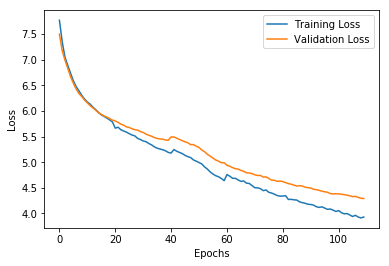

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(110), train_list, label = 'Training Loss')
plt.plot(range(110), val_list, label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()